In [1]:
import tensorflow as tf
import numpy as py
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import preprocessing
import urllib.request
import os
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
dataset_url='https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv'
dataset_dir='./datasets/'
dataset_path='datasets/titanic3.csv'

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
if not os.path.isfile(dataset_path):
    result=urllib.request.urlretrieve(dataset_url,dataset_path)
    print('dataset does not exist, downloading it now:',result)
else: print(dataset_path,'dataset found!')

model_log_dir='./model_logs/'
model_saving_dir='./model_saving/'
model_saving_path='./model_saving/titanic.ckpt'

if not os.path.exists(model_log_dir):
    os.makedirs(model_log_dir)
if not os.path.exists(model_saving_dir):
    os.makedirs(model_saving_dir)


datasets/titanic3.csv dataset found!


In [3]:
df=pd.read_csv(dataset_path)
selected_cols=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
df_selected=df[selected_cols]

'''
df_selected.isnull().sum()
df_selected[df_selected.isnull().values==True]
'''

'\ndf_selected.isnull().sum()\ndf_selected[df_selected.isnull().values==True]\n'

In [4]:
df_selected=df_selected.sample(frac=1)
df_selected['age']=df_selected['age'].fillna(df_selected['age'].mean())
df_selected['fare']=df_selected['fare'].fillna(df_selected['fare'].mean())
df_selected['embarked']=df_selected['embarked'].fillna('S')
df_selected['embarked']=df_selected['embarked'].map({'C':0,'Q':1,'S':2}).astype(int)
df_selected['sex']=df_selected['sex'].map({'female':0,'male':1}).astype(int)
df_selected=df_selected.drop(['name'],axis=1)

In [5]:
feature=df_selected.values[:,1:]
label=df_selected.values[:,0]
feature=preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(feature)

train_num=int(len(feature)*0.8)
train_feature=feature[:train_num]
train_label=label[:train_num]
test_feature=feature[train_num:]
test_label=label[train_num:]

In [6]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64,input_dim=7,use_bias=True,kernel_initializer='uniform',bias_initializer='zeros',activation='relu'))
model.add(tf.keras.layers.Dense(units=32,activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.003),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


2023-03-13 14:51:38.249674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir=model_log_dir,histogram_freq=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_saving_path,save_weights_only=True,verbose=0,period=50)
]
if not os.path.isfile(model_saving_path+'.index'):
    model_history=model.fit(x=train_feature,y=train_label,validation_split=0.2,epochs=50,batch_size=50,callbacks=callbacks,verbose=0)
    print('model saving file does not exist, training and saving it now...')
else:
    model.load_weights(tf.train.latest_checkpoint(model_saving_dir))
    print('model saving file found! load the weight into model...')

model saving file does not exist, training and saving it now...


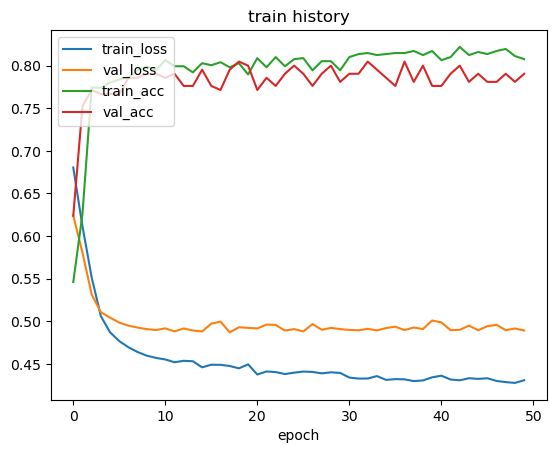

In [8]:
def show_train_history(model_history,train_loss,val_loss,train_acc,val_acc):
    plt.plot(model_history.history[train_loss])
    plt.plot(model_history.history[val_loss])
    plt.plot(model_history.history[train_acc])
    plt.plot(model_history.history[val_acc])
    plt.title('train history')
    plt.xlabel('epoch')
    plt.legend(['train_loss','val_loss','train_acc','val_acc'],loc='upper left')
    plt.show()

show_train_history(model_history,'loss','val_loss','accuracy','val_accuracy')

In [9]:
test_loss,test_acc=model.evaluate(x=test_feature,y=test_label)

9/9 [==============================] - 0s 1ms/step - loss: 0.4131 - accuracy: 0.8244


In [10]:
surv_probability=model.predict(feature)
df_selected.insert(len(df_selected.columns),'surv_probability',surv_probability)
df_selected.head(5)

41/41 [==============================] - 0s 786us/step


,survived,pclass,sex,age,sibsp,parch,fare,embarked,surv_probability
685,0,3,1,21.000000,0,0,16.10,2,0.143220
469,1,2,0,29.881138,0,0,12.35,1,0.924590
404,0,2,1,21.000000,0,0,13.00,2,0.251588
387,1,2,0,48.000000,0,2,36.75,2,0.753381
476,0,2,1,30.000000,1,1,26.00,2,0.187975
